In [1]:

#from google.colab import drive
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

import numpy as np
import os
from PIL import Image

from sklearn.model_selection import train_test_split
from imblearn.over_sampling import SMOTE
from sklearn.metrics import confusion_matrix

import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications import ResNet50, VGG16, InceptionV3
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D, Dropout, Flatten
from tensorflow.keras.models import Model
from tensorflow.keras.callbacks import EarlyStopping, LearningRateScheduler
from tensorflow.keras.optimizers.legacy import Adam
from keras.metrics import AUC

In [2]:
df_helper = pd.read_csv('/Users/dezmon/Library/Mobile Documents/com~apple~CloudDocs/Deep Learning_AI/Final Project/RSNA-256-helper.csv')

df_helper

,patient_id,image_id,laterality,view,age,implant,path,cancer
0,10006,462822612,0,1,61.0,0,/kaggle/input/rsna-breast-cancer-detection/tra...,0
1,10006,1459541791,0,5,61.0,0,/kaggle/input/rsna-breast-cancer-detection/tra...,0
2,10006,1864590858,1,5,61.0,0,/kaggle/input/rsna-breast-cancer-detection/tra...,0
3,10006,1874946579,1,1,61.0,0,/kaggle/input/rsna-breast-cancer-detection/tra...,0
4,10011,220375232,0,1,55.0,0,/kaggle/input/rsna-breast-cancer-detection/tra...,0
...,...,...,...,...,...,...,...,...
54701,9973,1729524723,1,5,43.0,0,/kaggle/input/rsna-breast-cancer-detection/tra...,0
54702,9989,63473691,0,5,60.0,0,/kaggle/input/rsna-breast-cancer-detection/tra...,0
54703,9989,1078943060,0,1,60.0,0,/kaggle/input/rsna-breast-cancer-detection/tra...,0
54704,9989,398038886,1,5,60.0,0,/kaggle/input/rsna-breast-cancer-detection/tra...,0


In [3]:
# Load the directory containing the images
image_directory = '/Users/dezmon/Library/Mobile Documents/com~apple~CloudDocs/Deep Learning_AI/Final Project/RSNA-516/'
image_sizes = []
image_paths = []
# Iterate over each image in the directory
for image_name in os.listdir(image_directory):
    if image_name.lower().endswith(('.png', '.jpg', '.jpeg', '.bmp', '.gif', '.tif', '.tiff')):
        image_path = os.path.join(image_directory, image_name)
        image = Image.open(image_path)
        image_sizes.append(image.size)  # Store image size (width, height)
        image_paths.append(image_path)

# Convert to numpy array for analysis
image_sizes = np.array(image_sizes)

In [4]:
# Construct the image_path column dynamically
df_helper['image_path'] = '/Users/dezmon/Library/Mobile Documents/com~apple~CloudDocs/Deep Learning_AI/Final Project/RSNA-516/' + df_helper['patient_id'].astype(str) + '_' + df_helper['image_id'].astype(str) + '.png'
# Getting Neccessary Files
df = df_helper[['image_path', 'cancer']]

cancer
1    1158
0    1158
Name: count, dtype: int64


<Axes: ylabel='count'>

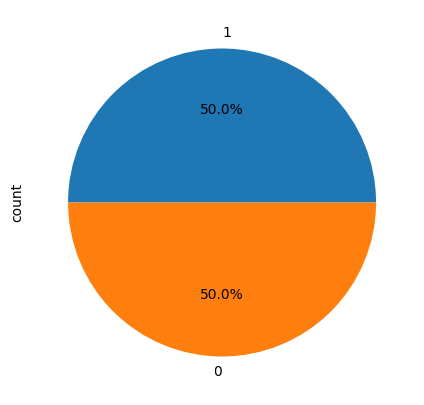

In [5]:
# Get the number of instances with class 1 (cancer)
num_cancer = df['cancer'].value_counts()[1]

# Get the indices of instances with class 1 (cancer)
indexs_cancer = np.array(df[df['cancer'] == 1].index)

# Get the indices of instances with class 0 (not cancer)
indexs_not_cancer = np.array(df[df['cancer'] == 0].index)

# Get indices of instances with class 0 (not cancer) randomly sampled with the same amount as class 1 (cancer)
indexs_not_cancer_balanced = np.random.choice(indexs_not_cancer, num_cancer, replace=False)

# Concatenate indices of instances with class 0 and 1
indexs_balanced = np.concatenate([indexs_cancer, indexs_not_cancer_balanced])

# Create a new dataframe with balanced classes
df_balanced = df.iloc[indexs_balanced, :]

# Check the class distribution after balancing
print(df_balanced['cancer'].value_counts())

# Plot pie chart to visualize the balanced class distribution
df_balanced['cancer'].value_counts().plot.pie(autopct='%.1f%%', figsize=(5, 5))

In [6]:
X_train, X_val_test, y_train, y_val_test = train_test_split(df_balanced['image_path'], df_balanced['cancer'], test_size=0.4, random_state=42, stratify = df_balanced['cancer'])
X_val, X_test, y_val, y_test = train_test_split(X_val_test, y_val_test, test_size=0.5, random_state=42, stratify=y_val_test)


In [7]:
# ImageDataGenerator for data augmentation and preprocessing
train_datagen = ImageDataGenerator(
    rescale=1./255,
    #zoom_range=0.4, # Randomly rotate images by up to 40 degrees
    brightness_range = [0.8,1.2], # Randomly adjust brightness between 0.8 and 1.2
    horizontal_flip=True
)
val_datagen = ImageDataGenerator(rescale=1./255)
test_datagen = ImageDataGenerator(rescale=1./255)

# Parameters
batch_size = 32
target_size = (299, 299)  # InceptionNetV3 input size

In [8]:
# Flow from DataFrame
train_generator = train_datagen.flow_from_dataframe(
    dataframe=pd.DataFrame({'image_path': X_train, 'cancer': y_train.astype(str)}),
    x_col='image_path',
    y_col='cancer',
    target_size=target_size,
    batch_size=batch_size,
    class_mode='binary',
    shuffle=True
)

val_generator = val_datagen.flow_from_dataframe(
    dataframe=pd.DataFrame({'image_path': X_val, 'cancer': y_val.astype(str)}),
    x_col='image_path',
    y_col='cancer',
    target_size=target_size,
    batch_size=batch_size,
    class_mode='binary',
    shuffle=False
)

test_generator = test_datagen.flow_from_dataframe(
    dataframe=pd.DataFrame({'image_path': X_test, 'cancer': y_test.astype(str)}),
    x_col='image_path',
    y_col='cancer',
    target_size=target_size,
    batch_size=batch_size,
    class_mode='binary',
    shuffle=False
)

Found 1389 validated image filenames belonging to 2 classes.
Found 463 validated image filenames belonging to 2 classes.
Found 464 validated image filenames belonging to 2 classes.


In [9]:
def plot_learning(history):
    tgts = ['loss', 'accuracy']
    vtgts = ['val_loss', 'val_accuracy']

    for tgt, val_tgt in zip(tgts, vtgts):
      plt.figure()
      plt.plot(history.history[tgt], label=tgt)
      plt.plot(history.history[val_tgt], label=val_tgt)
      plt.xlabel('Epoch')
      #plt.ylabel(ylab)
      plt.legend()
      plt.title(f"Training and validation {tgt}")

In [12]:
# Define early stopping callback
early_stopping = EarlyStopping(monitor='val_loss', patience=3, restore_best_weights=True)

# Initial learning rate
initial_learning_rate = 0.1

In [13]:
def create_model2(learning_rate):
    # Load InceptionV3 base model with pre-trained weights
    inceptionv3_base = InceptionV3(weights='imagenet', include_top=False)

    for layer in inceptionv3_base.layers:
        if isinstance(layer, tf.keras.layers.BatchNormalization):
            layer.trainable = True

    # Add custom layers on top of the base model
    x = inceptionv3_base.output
    x = GlobalAveragePooling2D()(x)
    x = Dense(256, activation='relu')(x)
    x = Dropout(0.5)(x)
    predictions = Dense(1, activation='sigmoid')(x)

    # Create the model
    model = Model(inputs=inceptionv3_base.input, outputs=predictions)

    # Compile the model
    optimizer = Adam(learning_rate=learning_rate)
    model.compile(optimizer=optimizer, loss='binary_crossentropy', metrics=['accuracy', AUC()])

    return model

In [14]:
# Define hyperparameters
learning_rates = [0.001, 0.01]
batch_sizes = [32, 64]
epochs = 10
# Define lists to store models and histories
models_list = []
histories_list = []
hyperparameter_list = []
for lr in learning_rates:
    for batch_size in batch_sizes:
        print(f"Training model with learning rate: {lr} and batch size: {batch_size}")
        model = create_model2(lr)
        history = model.fit(train_generator, validation_data=val_generator, epochs=epochs, batch_size=batch_size, callbacks=[early_stopping])

        models_list.append(model)
        histories_list.append(history)

        # Store hyperparameters for each model
        hyperparameters = {'learning_rate': lr, 'batch_size': batch_size}
        hyperparameter_list.append(hyperparameters)

Training model with learning rate: 0.001 and batch size: 32


Epoch 1/10


2024-05-02 08:42:06.532740: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:117] Plugin optimizer for device_type GPU is enabled.
2024-05-02 08:42:07.273031: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:961] model_pruner failed: INVALID_ARGUMENT: Graph does not contain terminal node Adam/AssignAddVariableOp.


44/44 [==============================] - 52s 1s/step - loss: 0.8154 - accuracy: 0.5205 - auc_1: 0.5149 - val_loss: 2632347.0000 - val_accuracy: 0.5011 - val_auc_1: 0.5000
Epoch 2/10
44/44 [==============================] - 41s 921ms/step - loss: 0.7855 - accuracy: 0.4939 - auc_1: 0.4932 - val_loss: 0.7595 - val_accuracy: 0.5011 - val_auc_1: 0.5000
Epoch 3/10
44/44 [==============================] - 41s 927ms/step - loss: 0.7521 - accuracy: 0.4831 - auc_1: 0.4764 - val_loss: 2613.0398 - val_accuracy: 0.4989 - val_auc_1: 0.5000
Epoch 4/10
44/44 [==============================] - 40s 918ms/step - loss: 0.7322 - accuracy: 0.4932 - auc_1: 0.4817 - val_loss: 3.9020 - val_accuracy: 0.5054 - val_auc_1: 0.4997
Epoch 5/10
44/44 [==============================] - 41s 928ms/step - loss: 0.7185 - accuracy: 0.4831 - auc_1: 0.4822 - val_loss: 1.0583 - val_accuracy: 0.5097 - val_auc_1: 0.5120
Training model with learning rate: 0.001 and batch size: 64


Epoch 1/10


2024-05-02 08:45:43.659918: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:961] model_pruner failed: INVALID_ARGUMENT: Graph does not contain terminal node Adam/AssignAddVariableOp.


44/44 [==============================] - 55s 1s/step - loss: 0.8965 - accuracy: 0.5054 - auc_2: 0.4996 - val_loss: 4.1865 - val_accuracy: 0.4989 - val_auc_2: 0.4949
Epoch 2/10
44/44 [==============================] - 41s 929ms/step - loss: 0.7337 - accuracy: 0.5126 - auc_2: 0.5126 - val_loss: 2.8571 - val_accuracy: 0.5076 - val_auc_2: 0.5131
Epoch 3/10
44/44 [==============================] - 41s 924ms/step - loss: 0.7214 - accuracy: 0.4860 - auc_2: 0.5072 - val_loss: 0.6915 - val_accuracy: 0.5097 - val_auc_2: 0.5273
Epoch 4/10
44/44 [==============================] - 41s 924ms/step - loss: 0.7153 - accuracy: 0.4860 - auc_2: 0.4835 - val_loss: 2.2101 - val_accuracy: 0.4838 - val_auc_2: 0.4532
Epoch 5/10
44/44 [==============================] - 41s 925ms/step - loss: 0.7012 - accuracy: 0.5133 - auc_2: 0.5055 - val_loss: 1.7634 - val_accuracy: 0.5616 - val_auc_2: 0.5580
Epoch 6/10
44/44 [==============================] - 41s 938ms/step - loss: 0.7114 - accuracy: 0.5054 - auc_2: 0.5207 - 

Epoch 1/10


2024-05-02 08:50:04.437542: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:961] model_pruner failed: INVALID_ARGUMENT: Graph does not contain terminal node Adam/AssignAddVariableOp.


44/44 [==============================] - 59s 1s/step - loss: 1.5088 - accuracy: 0.5104 - auc_3: 0.5082 - val_loss: 5949255843840.0000 - val_accuracy: 0.4989 - val_auc_3: 0.5000
Epoch 2/10
44/44 [==============================] - 42s 955ms/step - loss: 0.7929 - accuracy: 0.4824 - auc_3: 0.4737 - val_loss: 685301.1875 - val_accuracy: 0.4989 - val_auc_3: 0.4978
Epoch 3/10
44/44 [==============================] - 41s 920ms/step - loss: 0.7353 - accuracy: 0.4845 - auc_3: 0.4884 - val_loss: 3438.0950 - val_accuracy: 0.4989 - val_auc_3: 0.5109
Epoch 4/10
44/44 [==============================] - 41s 926ms/step - loss: 0.7064 - accuracy: 0.4867 - auc_3: 0.4782 - val_loss: 22.9254 - val_accuracy: 0.5464 - val_auc_3: 0.5545
Epoch 5/10
44/44 [==============================] - 41s 925ms/step - loss: 0.7076 - accuracy: 0.4953 - auc_3: 0.4918 - val_loss: 1.0855 - val_accuracy: 0.5032 - val_auc_3: 0.4800
Epoch 6/10
44/44 [==============================] - 41s 922ms/step - loss: 0.6999 - accuracy: 0.50

Epoch 1/10


2024-05-02 08:57:13.506930: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:961] model_pruner failed: INVALID_ARGUMENT: Graph does not contain terminal node Adam/AssignAddVariableOp.


44/44 [==============================] - 65s 1s/step - loss: 1.8817 - accuracy: 0.5320 - auc_4: 0.5348 - val_loss: 2909672570880.0000 - val_accuracy: 0.5011 - val_auc_4: 0.5000
Epoch 2/10
44/44 [==============================] - 43s 978ms/step - loss: 1.6347 - accuracy: 0.5112 - auc_4: 0.5207 - val_loss: 97069648.0000 - val_accuracy: 0.5011 - val_auc_4: 0.5000
Epoch 3/10
44/44 [==============================] - 42s 961ms/step - loss: 1.1492 - accuracy: 0.4932 - auc_4: 0.5069 - val_loss: 44183.8203 - val_accuracy: 0.5011 - val_auc_4: 0.5138
Epoch 4/10
44/44 [==============================] - 42s 947ms/step - loss: 0.7944 - accuracy: 0.5112 - auc_4: 0.5227 - val_loss: 3.6766 - val_accuracy: 0.5292 - val_auc_4: 0.4987
Epoch 5/10
44/44 [==============================] - 42s 943ms/step - loss: 0.8099 - accuracy: 0.4824 - auc_4: 0.4828 - val_loss: 1.3432 - val_accuracy: 0.4989 - val_auc_4: 0.4687
Epoch 6/10
44/44 [==============================] - 42s 946ms/step - loss: 0.8180 - accuracy: 0.

In [15]:
best_model = None
best_accuracy = 0.0
best_hyperparameters = None

for model, history, hyperparameters in zip(models_list, histories_list, hyperparameter_list):
    val_accuracy = history.history['val_accuracy'][-1]  # Get the last validation accuracy

    if val_accuracy > best_accuracy:
        best_model = model
        best_accuracy = val_accuracy
        best_hyperparameters = hyperparameters
        best_history = history

In [16]:
# Find the index of the best model
best_model_index = models_list.index(best_model)

# Retrieve the hyperparameters of the best model
best_hyperparameters = hyperparameter_list[best_model_index]
# Print the results
print("Best model hyperparameters:")
print(best_hyperparameters)

Best model hyperparameters:
{'learning_rate': 0.01, 'batch_size': 64}


In [17]:
# Evaluate the best model on the test dataset
test_loss, test_accuracy, test_auc = best_model.evaluate(test_generator)

print("Test Loss:", test_loss)
print("Test Accuracy:", test_accuracy)
print("Test AUC:", test_auc)

15/15 [==============================] - 7s 452ms/step - loss: 0.6814 - accuracy: 0.5194 - auc_4: 0.5194
Test Loss: 0.6814479827880859
Test Accuracy: 0.5193965435028076
Test AUC: 0.5193965435028076


In [18]:
from sklearn.metrics import roc_curve, auc
# Get true labels of test data
test_pred1 = best_model.predict(test_generator)
test_true = test_generator.classes
# Calculate ROC curve
fpr, tpr, thresholds = roc_curve(test_true, test_pred1)
#roc_auc = auc(fpr, tpr)

# Find optimal threshold
optimal_idx = np.argmax(tpr - fpr)
optimal_threshold = thresholds[optimal_idx]

# Threshold predictions based on optimal threshold
test_pred_binary1 = (test_pred1 > optimal_threshold).astype(int)

15/15 [==============================] - 6s 309ms/step


In [19]:
from sklearn.metrics import classification_report# Generate classification report
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score

In [20]:
accuracy = accuracy_score(test_true, test_pred_binary1)
precision = precision_score(test_true, test_pred_binary1)
recall = recall_score(test_true, test_pred_binary1)
f1 = f1_score(test_true, test_pred_binary1)


print("Accuracy:", accuracy)
print("Precision:", precision)
print("Recall:", recall)
print("F1 Score:", f1)

Accuracy: 0.4978448275862069
Precision: 0.0
Recall: 0.0
F1 Score: 0.0


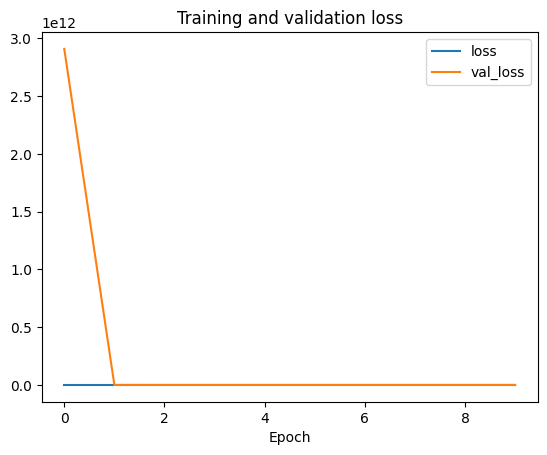

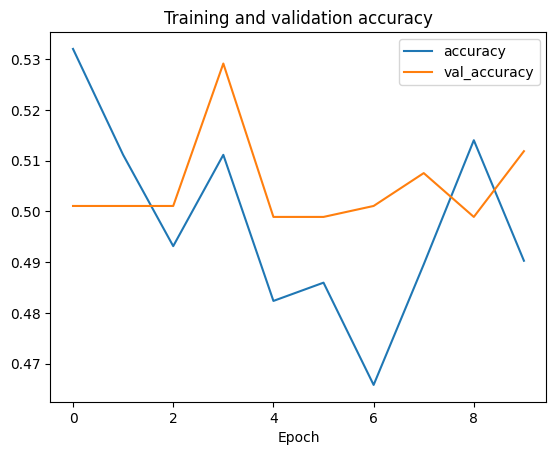

In [21]:
def plot_learning(history):
    tgts = ['loss', 'accuracy']
    vtgts = ['val_loss', 'val_accuracy']

    for tgt, val_tgt in zip(tgts, vtgts):
        plt.figure()
        plt.plot(history.history[tgt], label=tgt)
        plt.plot(history.history[val_tgt], label=val_tgt)
        plt.xlabel('Epoch')
        plt.legend()
        plt.title(f"Training and validation {tgt}")

# Assuming you have found the best model, its corresponding history is stored in best_history
plot_learning(best_history)

In [22]:
def create_model3(learning_rate):
    # Load InceptionV3 base model with pre-trained weights
    inceptionv3_base = InceptionV3(weights='imagenet', include_top=False)
    # Calculate the index to split the layers
    split_index = len(inceptionv3_base.layers) // 2

    # Set layers before the split index as frozen and layers after as trainable
    for i, layer in enumerate(inceptionv3_base.layers):
        if i < split_index:
            layer.trainable = False
        else:
            layer.trainable = True

    # Add custom layers on top of the base model
    x = inceptionv3_base.output
    x = GlobalAveragePooling2D()(x)
    x = Dense(256, activation='relu')(x)
    x = Dropout(0.5)(x)
    predictions = Dense(1, activation='sigmoid')(x)

    # Create the model
    model = Model(inputs=inceptionv3_base.input, outputs=predictions)

    # Compile the model
    optimizer = Adam(learning_rate=learning_rate)
    model.compile(optimizer=optimizer, loss='binary_crossentropy', metrics=['accuracy', AUC()])

    return model

In [23]:
# Define hyperparameters
learning_rates = [0.001, 0.01]
batch_sizes = [32, 64]
epochs = 10
# Define lists to store models and histories
models_list1 = []
histories_list1 = []
hyperparameter_list1 = []

In [24]:
for lr in learning_rates:
    for batch_size in batch_sizes:
        print(f"Training model with learning rate: {lr} and batch size: {batch_size}")
        model1 = create_model3(lr)
        history1 = model1.fit(train_generator, validation_data=val_generator, epochs=epochs, batch_size=batch_size, callbacks=[early_stopping])

        models_list1.append(model1)
        histories_list1.append(history1)

        # Store hyperparameters for each model
        hyperparameters = {'learning_rate': lr, 'batch_size': batch_size}
        hyperparameter_list1.append(hyperparameters)

Training model with learning rate: 0.001 and batch size: 32


Epoch 1/10


: 

In [ ]:
best_model = None
best_accuracy = 0.0
best_hyperparameters = None

for model, history, hyperparameters in zip(models_list1, histories_list1, hyperparameter_list1):
    val_accuracy = history.history['val_accuracy'][-1]  # Get the last validation accuracy

    if val_accuracy > best_accuracy:
        best_model = model
        best_accuracy = val_accuracy
        best_hyperparameters = hyperparameters
        best_history = history

In [ ]:
# Find the index of the best model
best_model_index = models_list1.index(best_model)

# Retrieve the hyperparameters of the best model
best_hyperparameters = hyperparameter_list1[best_model_index]
# Print the results
print("Best model hyperparameters:")
print(best_hyperparameters)

In [ ]:
best_model1 = None
best_accuracy1 = 0.0
best_hyperparameters1 = None

for model, history, hyperparameters in zip(models_list1, histories_list1, hyperparameter_list1):
    val_accuracy = history.history['val_accuracy'][-1]  # Get the last validation accuracy

    if val_accuracy > best_accuracy:
        best_model1 = model
        best_accuracy1 = val_accuracy
        best_hyperparameters1 = hyperparameters
        best_history1 = history

In [ ]:
# Evaluate the best model on the test dataset
test_loss, test_accuracy, test_auc = best_model.evaluate(test_generator)

print("Test Loss:", test_loss)
print("Test Accuracy:", test_accuracy)
print("Test AUC:", test_auc)

In [ ]:
from sklearn.metrics import roc_curve, auc
# Get true labels of test data
test_pred1 = best_model.predict(test_generator)
test_true = test_generator.classes
# Calculate ROC curve
fpr, tpr, thresholds = roc_curve(test_true, test_pred1)
#roc_auc = auc(fpr, tpr)

# Find optimal threshold
optimal_idx = np.argmax(tpr - fpr)
optimal_threshold = thresholds[optimal_idx]

# Threshold predictions based on optimal threshold
test_pred_binary1 = (test_pred1 > optimal_threshold).astype(int)

In [ ]:
from sklearn.metrics import classification_report# Generate classification report
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score
accuracy2 = accuracy_score(test_true, test_pred_binary1)
precision2 = precision_score(test_true, test_pred_binary1)
recall2 = recall_score(test_true, test_pred_binary1)
f12 = f1_score(test_true, test_pred_binary1)


print("Accuracy:", accuracy2)
print("Precision:", precision2)
print("Recall:", recall2)
print("F1 Score:", f12)

In [ ]:
def plot_learning(history):
    tgts = ['loss', 'accuracy']
    vtgts = ['val_loss', 'val_accuracy']

    for tgt, val_tgt in zip(tgts, vtgts):
        plt.figure()
        plt.plot(history.history[tgt], label=tgt)
        plt.plot(history.history[val_tgt], label=val_tgt)
        plt.xlabel('Epoch')
        plt.legend()
        plt.title(f"Training and validation {tgt}")

# Assuming you have found the best model, its corresponding history is stored in best_history
plot_learning(best_history)